In [1]:
#
# Initialization
#

import os
import sys

import ipynbname
from pathlib import Path

# Set notebook's src module path. Note that you may have to update your IDE's project settings to do the same for the
#  local library imports to work the same
MODULE_PATH = ipynbname.path().parent.parent
sys.path.append(str(MODULE_PATH))

# Keep paths consistent throughout notebook
os.chdir(MODULE_PATH)

# This should always be `./src`
print(f"Current working directory [{os.getcwd()}]")

# Place all local artifacts in a disposable, git-ignored directory
local_artifact_dir = Path(os.getcwd()).parent / "out"
local_artifact_dir.mkdir(parents=True, exist_ok=True)

# Autoreload imports at the beginning of cell execution.
#  https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

Current working directory [/Users/jbeckman/projects/capia/src]


In [2]:
#
# Setup utils
#

import subprocess

from utils.logger_util import LoggerUtil
from utils.utils import Utils
from utils import config

LOGGER = LoggerUtil(config.MODEL_ID, local_artifact_dir / "logs")
UTILS = Utils(LOGGER)

UTILS.describe_env()

AWS_INSTANCE = 'ml.m5.large'
LOCAL_INSTANCE = 'local'
try:
    if subprocess.call('nvidia-smi') == 0:
        LOCAL_INSTANCE = 'local_gpu'
except:
    LOGGER.log("The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU "
          "computation")

# Change this to your desired instance type
INSTANCE_TYPE = AWS_INSTANCE
IS_LOCAL = LOCAL_INSTANCE == INSTANCE_TYPE

2021-03-26 13:33:26.938075 Background logger started
2021-03-26 13:33:26.938571 The model id is [giia-0.5.2]
2021-03-26 13:33:26.938786 The MXNet version is [1.7.0]
2021-03-26 13:33:26.939020 The GPU count is [0]
2021-03-26 13:33:26.943207 The nvidia-smi binary was not found and thus GPU computation is not supported. Using the default CPU computation


In [3]:
#
# Parse dataset
#

from data_processing.parse import Parse

PARSE = Parse(LOGGER)

dataset_dir_path = local_artifact_dir / "datasets"

# Creates train and test dataset CSVs
PARSE.split_train_test_dataset(dataset_dir_path)

2021-03-26 13:33:28.583756 First sample:
2021-03-26 13:33:28.587323 
                        open     high      low    close    volume
date                                                             
2017-08-17 04:00:00  4261.48  4280.56  4261.48  4261.48  2.189061
2021-03-26 13:33:28.587883 Last sample:
2021-03-26 13:33:28.590592 
                         open      high       low     close     volume
date                                                                  
2021-03-26 01:25:00  52151.39  52178.81  52108.76  52122.84  93.536227
2021-03-26 13:33:31.181557 Parsed train and test datasets can be found in [/Users/jbeckman/projects/capia/out/datasets]


In [40]:
#
# Setup local/aws environment. If aws, upload the datasets to S3
#

from data_processing.aws_handler import AWSHandler
from sagemaker import LocalSession

AWS_HANDLER = AWSHandler(LOGGER, config.MODEL_ID)

sagemaker_session = None

model_output_dir_path = local_artifact_dir / "models"
model_output_dir_path.mkdir(parents=True, exist_ok=True)

if IS_LOCAL:
    LOGGER.log("Notebook is set to local mode, not uploading to S3")

    dataset_dir_uri = f"file://{dataset_dir_path}"
    model_output_dir_uri = f"file://{model_output_dir_path}"

    sagemaker_session = LocalSession()
    sagemaker_session.config = {
        'local': {
            'local_code': True,
            'container_root': str(model_output_dir_path)
        }
    }
else:
    sagemaker_session = AWS_HANDLER.sagemaker_session

    AWS_HANDLER.upload_to_sagemaker_s3_bucket(dataset_dir_path, config.TRAIN_DATASET_FILENAME)
    AWS_HANDLER.upload_to_sagemaker_s3_bucket(dataset_dir_path, config.TEST_DATASET_FILENAME)
    dataset_dir_uri = AWS_HANDLER.s3_dataset_dir_uri

    model_output_dir_uri = AWS_HANDLER.s3_model_output_uri

LOGGER.log(f"Model output dir is [{model_output_dir_uri}]")

2021-03-26 14:31:26.415622 Data will be uploaded to [sagemaker-us-east-2-941048668662]
2021-03-26 14:31:26.636041 Overwriting existing file
2021-03-26 14:31:34.145776 Uploaded file to s3://sagemaker-us-east-2-941048668662/giia-0.5.2/train.csv
2021-03-26 14:31:34.146622 Data will be uploaded to [sagemaker-us-east-2-941048668662]
2021-03-26 14:31:34.203642 Overwriting existing file
2021-03-26 14:31:36.072306 Uploaded file to s3://sagemaker-us-east-2-941048668662/giia-0.5.2/test.csv
2021-03-26 14:31:36.073004 Model output dir is [s3://sagemaker-us-east-2-941048668662/giia-0.5.2/model]


In [5]:
#
# Configure sagemaker and estimator
#

from ml.train import Train

TRAIN = Train(LOGGER)

if IS_LOCAL:
    train_kwargs = {
        'checkpoint_local_path': model_output_dir_uri
        # 'checkpoint_local_path': str(model_output_dir_path)
    }
else:
    train_kwargs = {
        'checkpoint_s3_uri': model_output_dir_uri
    }

estimator = TRAIN.create_model(config.SM_ROLE, INSTANCE_TYPE, sagemaker_session, train_kwargs)
TRAIN.fit_model(estimator, dataset_dir_uri)

2021-03-26 17:34:07 Starting - Starting the training job...
2021-03-26 17:34:33 Starting - Launching requested ML instancesProfilerReport-1616780022: InProgress
......
2021-03-26 17:35:36 Starting - Preparing the instances for training......
2021-03-26 17:36:40 Downloading - Downloading input data...
2021-03-26 17:37:01 Training - Downloading the training image..2021-03-26 17:37:16,861 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-03-26 17:37:16,864 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-03-26 17:37:16,876 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"dropout_rate":0.209371,"epochs":1,"num_layers":4,"prediction_length":16}', 'SM_USER_ENTRY_POINT': 'deepar.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}',

In [44]:
#
# Load model and define test data and variables to visually evaluate the model
#

from gluonts.model.predictor import Predictor

import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice

if IS_LOCAL:
    # model_output_dir_path is basically the same path as it was before, though sagemaker appends a random temp
    # directory to the path. The path from TRAIN includes that random temp directory
    model_dir_path = TRAIN.model_data_path.parent.parent / "model"
else:
    model_dir_path = AWS_HANDLER.download_model_from_s3(str(TRAIN.model_data_path), model_output_dir_path)

LOGGER.log(f"Model dir is [{str(model_dir_path)}]")
predictor = Predictor.deserialize(Path(model_dir_path))

def plot_prob_forecasts(ts_list, forecast_list, plot_length=100):
    for target, forecast in islice(zip(ts_list, forecast_list), len(forecasts)):
        prediction_intervals = (50.0, 90.0)
        legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

        ax = target[-plot_length:].plot(figsize=(10, 7), linewidth=2)
        forecast.plot(prediction_intervals=prediction_intervals, color='g')
        plt.grid(which='both')
        plt.legend(legend, loc="upper left")
        plt.show()

2021-03-26 14:41:22.953526 Downloading [mxnet-training-2021-03-26-17-33-42-742/output/model.tar.gz] from s3 to [/Users/jbeckman/projects/capia/out/models/mxnet-training-2021-03-26-17-33-42-742/output/model.tar.gz]
2021-03-26 14:41:23.411411 Download complete
2021-03-26 14:41:23.412176 Extracting [/Users/jbeckman/projects/capia/out/models/mxnet-training-2021-03-26-17-33-42-742/output/model.tar.gz] to [/Users/jbeckman/projects/capia/out/models/mxnet-training-2021-03-26-17-33-42-742/model]
2021-03-26 14:41:23.416228 Extract complete
2021-03-26 14:41:23.416814 Model dir is [/Users/jbeckman/projects/capia/out/models/mxnet-training-2021-03-26-17-33-42-742/model]


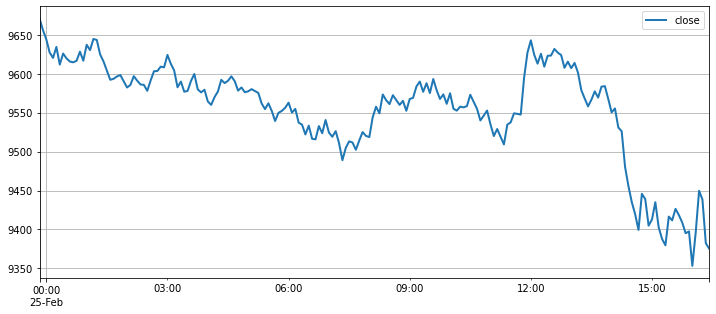

2021-03-26 14:41:33.255504 Number of sample paths: 100
2021-03-26 14:41:33.256013 Dimension of samples: (100, 16)
2021-03-26 14:41:33.256213 Start date of the forecast window: 2021-03-26 00:10:00
2021-03-26 14:41:33.256539 Frequency of the time series: 5min


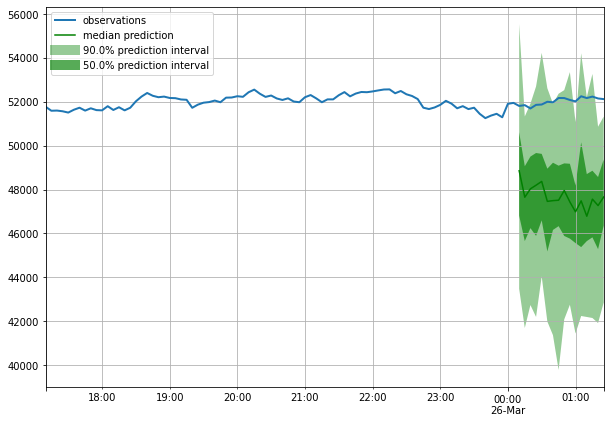

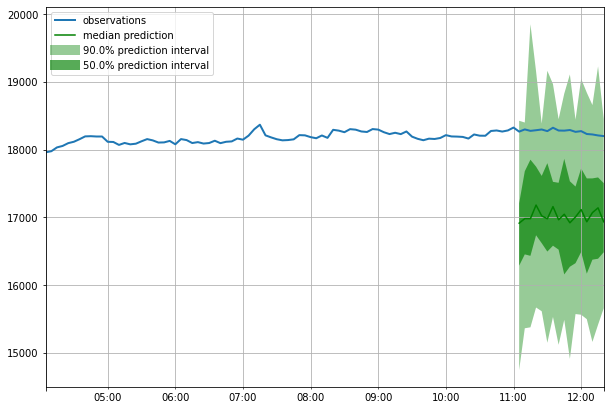

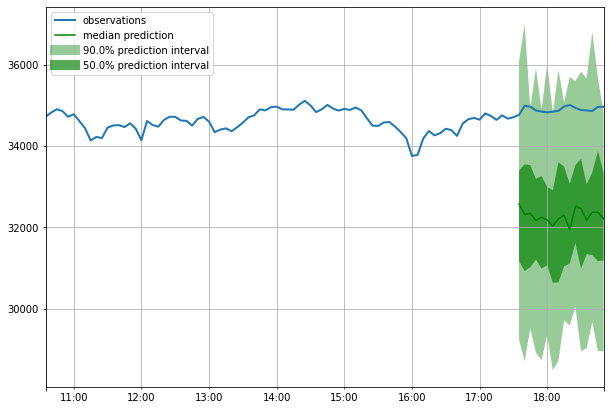

In [45]:
#
# Visually evaluate the model by graphing some prediction test results
#

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset

test_dataset_filename = dataset_dir_path / config.TEST_DATASET_FILENAME
df = pd.read_csv(filepath_or_buffer=test_dataset_filename, header=0, index_col=0)

test_data = ListDataset(
    [
        # This is first so we can easily graph the entire test dataset below
        {"start": df.index[0], "target": df["close"][:]},
        {"start": df.index[0], "target": df["close"][:"2020-11-20 12:20:00"]},
        {"start": df.index[0], "target": df["close"][:"2021-01-20 18:50:00"]}
    ],
    freq="5min"
)

to_pandas(next(iter(test_data)))[:200].plot(figsize=(12, 5), linewidth=2)
plt.grid()
plt.legend(["close"])
plt.show()

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
forecast_entry = forecasts[0]
tss = list(ts_it)

LOGGER.log(f"Number of sample paths: {forecast_entry.num_samples}")
LOGGER.log(f"Dimension of samples: {forecast_entry.samples.shape}")
LOGGER.log(f"Start date of the forecast window: {forecast_entry.start_date}")
LOGGER.log(f"Frequency of the time series: {forecast_entry.freq}")

plot_prob_forecasts(tss, forecasts)

In [ ]:
#
# NOTE: FURTHER CELLS ARE COMPATIBLE WITH AWS SAGEMAKER ONLY, LOCAL MODE WILL NOT WORK
# Hyperparameter tune the model
#

from ml.tune import Tune

TUNE = Tune(UTILS, LOGGER)

train_dataset_uri = f"{dataset_dir_uri}/{config.TRAIN_DATASET_FILENAME}"
test_dataset_uri = f"{dataset_dir_uri}/{config.TEST_DATASET_FILENAME}"

# Note: Feel free to tune the tuner, i.e. update max number of jobs and hyperparameters. Default is 10 jobs, but you
# may want to change this as you refine the model. Additionally, if you find the best model has a parameter at the
# end of the range you gave it, then you should look to move that range to determine if the model performs better
# along that vector
tuner = TUNE.create_tuner(estimator)
TUNE.fit_tuner(tuner, dataset_dir_uri)

2021-03-26 14:45:54.821651 Hyperparameter [epochs] default value is [20]. The min range will be set to [10] and the max range will be set to [30]
2021-03-26 14:45:54.822230 Hyperparameter [prediction_length] default value is [16]. The min range will be set to [8] and the max range will be set to [24]
2021-03-26 14:45:54.822597 Hyperparameter [num_layers] default value is [4]. The min range will be set to [2] and the max range will be set to [9]
2021-03-26 14:45:54.822865 Hyperparameter [dropout_rate] default value is [0.209371]. The min range will be set to [0.1046855] and the max range will be set to [0.2]
..............................................

In [ ]:
#
# Get updates for Hyperparameter tune job. Ensure this is completed before going to the next cell
#

TUNE.get_tune_job_update()

In [ ]:
#
# Evaluate the metrics of the tune job
#

TUNE.report_job_analytics()
